In [1]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import math
import cv2
%matplotlib inline
from moviepy.editor import VideoFileClip
from IPython.display import HTML

ref: https://github.com/kemfic/simple-lane-detection/blob/master/P1_LaneLines.ipynb

In [2]:
imageDir = '/Users/roczhang/Library/CloudStorage/OneDrive-个人/img/opencv/test_images/'
imageFiles = os.listdir(imageDir)

imageList = []

for i in range(0, len(imageFiles)):
    imageList.append(mpimg.imread(imageDir + imageFiles[i]))

print(imageFiles)

['solidYellowCurve.jpg', 'solidYellowLeft.jpg', 'solidYellowCurve2.jpg', 'solidWhiteRight.jpg', 'whiteCarLaneSwitch.jpg', 'solidWhiteCurve.jpg']


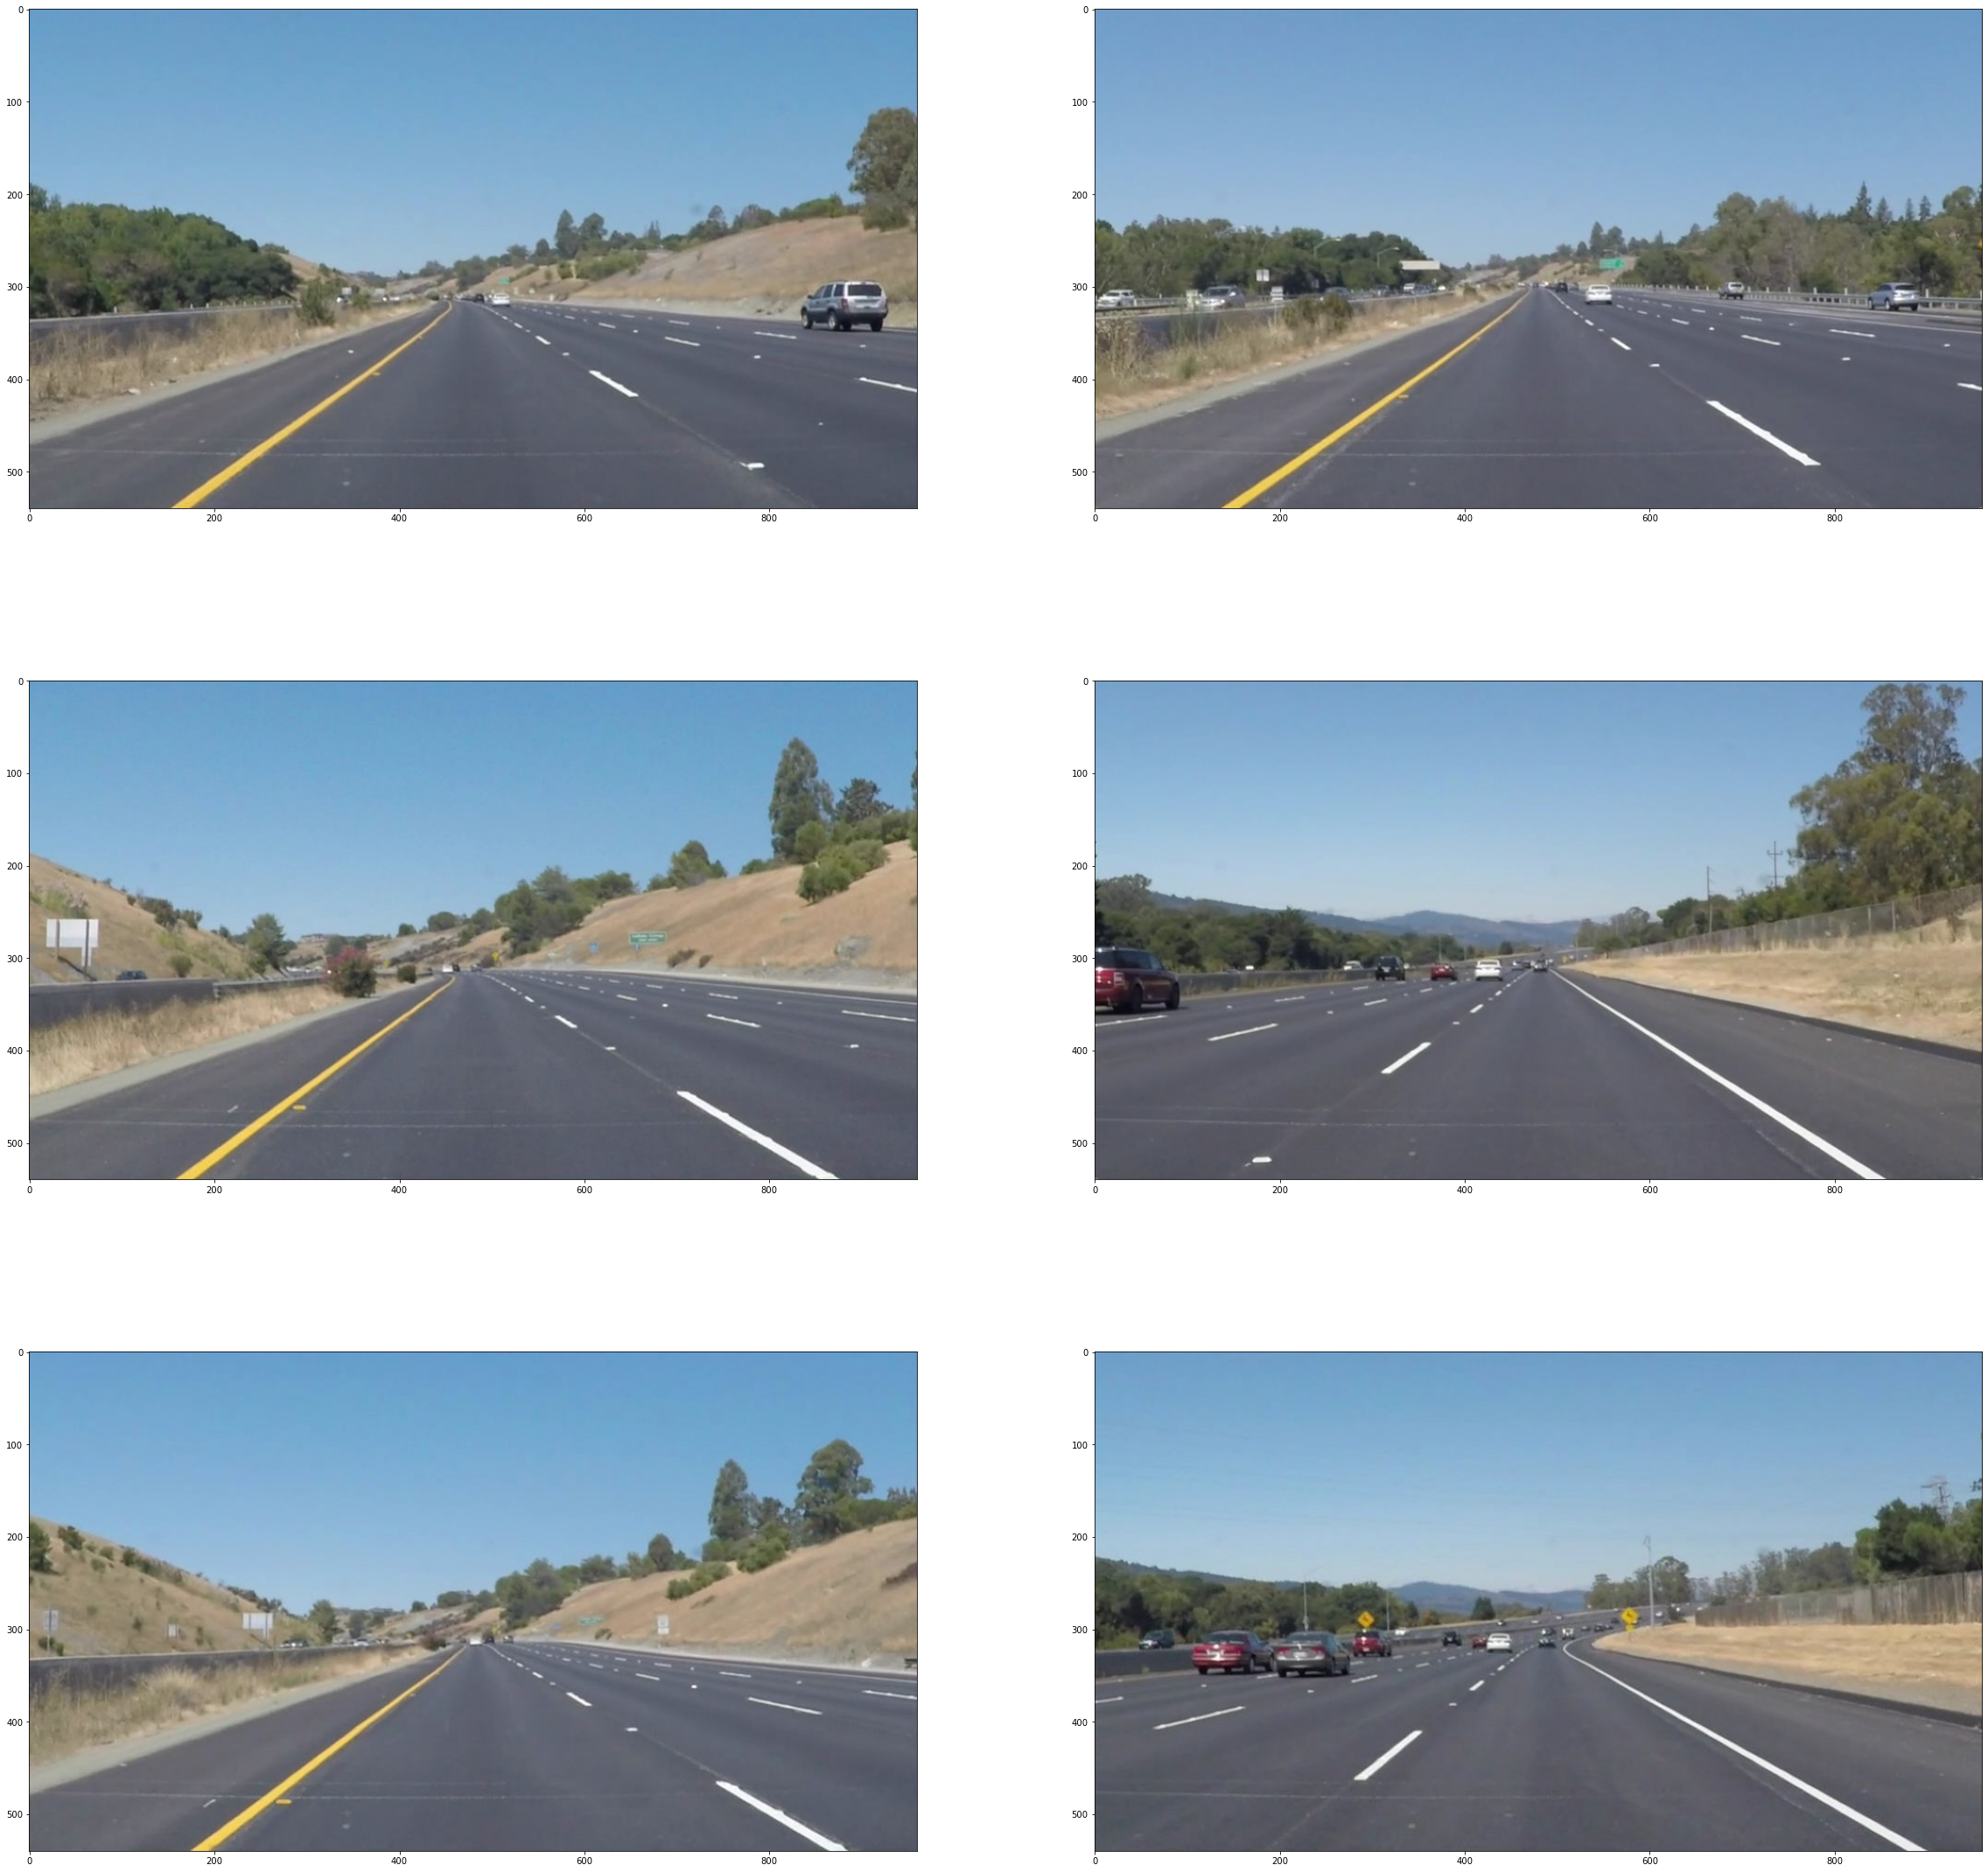

In [3]:
def display_images(images, cmap=None):
    plt.figure(figsize=(40,40))    
    for i, image in enumerate(images):
        plt.subplot(3,2,i+1)
        plt.imshow(image, cmap)
        plt.autoscale(tight=True)
    plt.show()
    
display_images(imageList)

Masking Unnecessary Colors
我们需要掩盖不必要的颜色和噪音，以防止检测到无关的线条。您可以通过对图像中的颜色值进行阈值来做到这一点。我们当前的图像使用RGB色彩空间，但由于噪音、阴影和阳光，RGB中的阈值效果不佳。

相反，我们可以使用HSL（色相、饱和度、亮度）色彩空间来过滤掉白色和黄色线条，为噪音、阴影和阳光造成的差异留出更多空间。

我们将使用两个口罩，一个用于白色，一个用于黄色。然后，我们将组合它们，并使用组合来屏蔽输入图像。

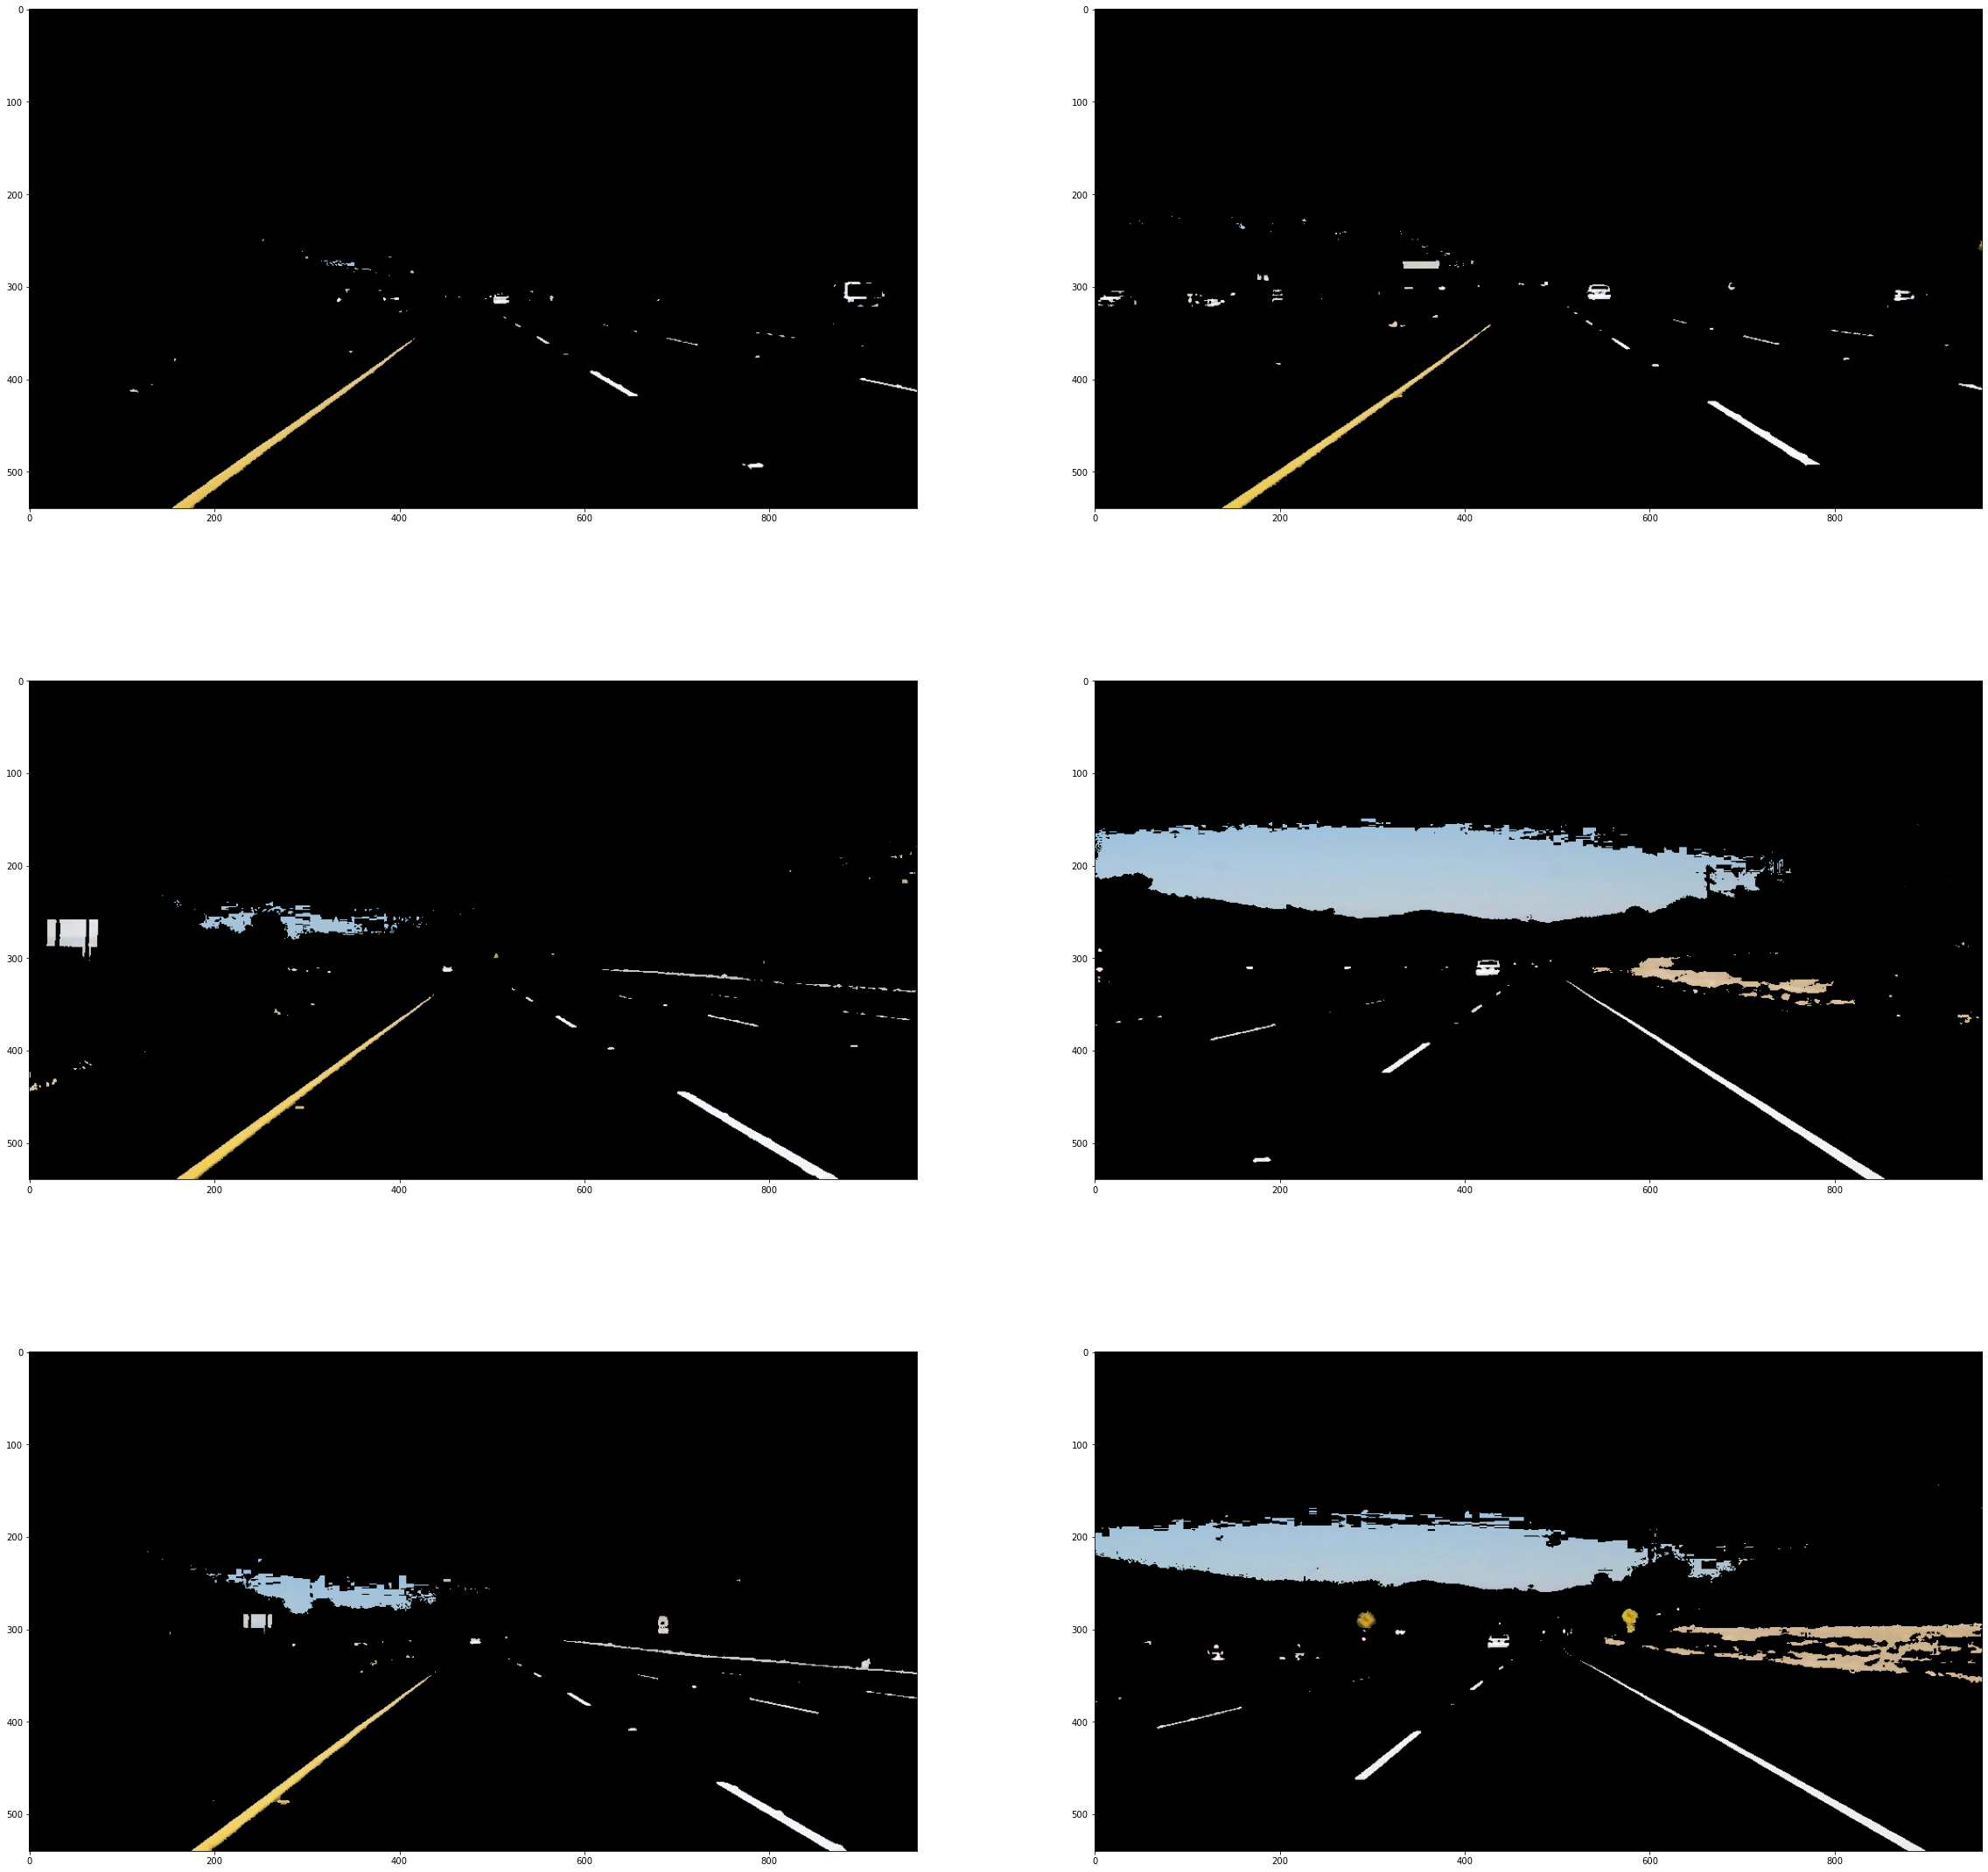

In [4]:
def color_filter(image):
    #convert to HLS to mask based on HLS
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    lower = np.array([0,190,0])
    upper = np.array([255,255,255])
    
    yellower = np.array([10,0,90])
    yelupper = np.array([50,255,255])
    
    yellowmask = cv2.inRange(hls, yellower, yelupper)    
    whitemask = cv2.inRange(hls, lower, upper)
    
    mask = cv2.bitwise_or(yellowmask, whitemask)  
    masked = cv2.bitwise_and(image, image, mask = mask)    
    


    return masked

filtered_img = list(map(color_filter, imageList))

display_images(filtered_img)

Region of Interest

您可能已经注意到，在之前的操作中，我们图像的某些部分不是车道线。我们需要删除这些并隔离车道线，我们将通过掩盖我们感兴趣的区域以外的所有内容来做到这一点，这些区域表示为多边形。

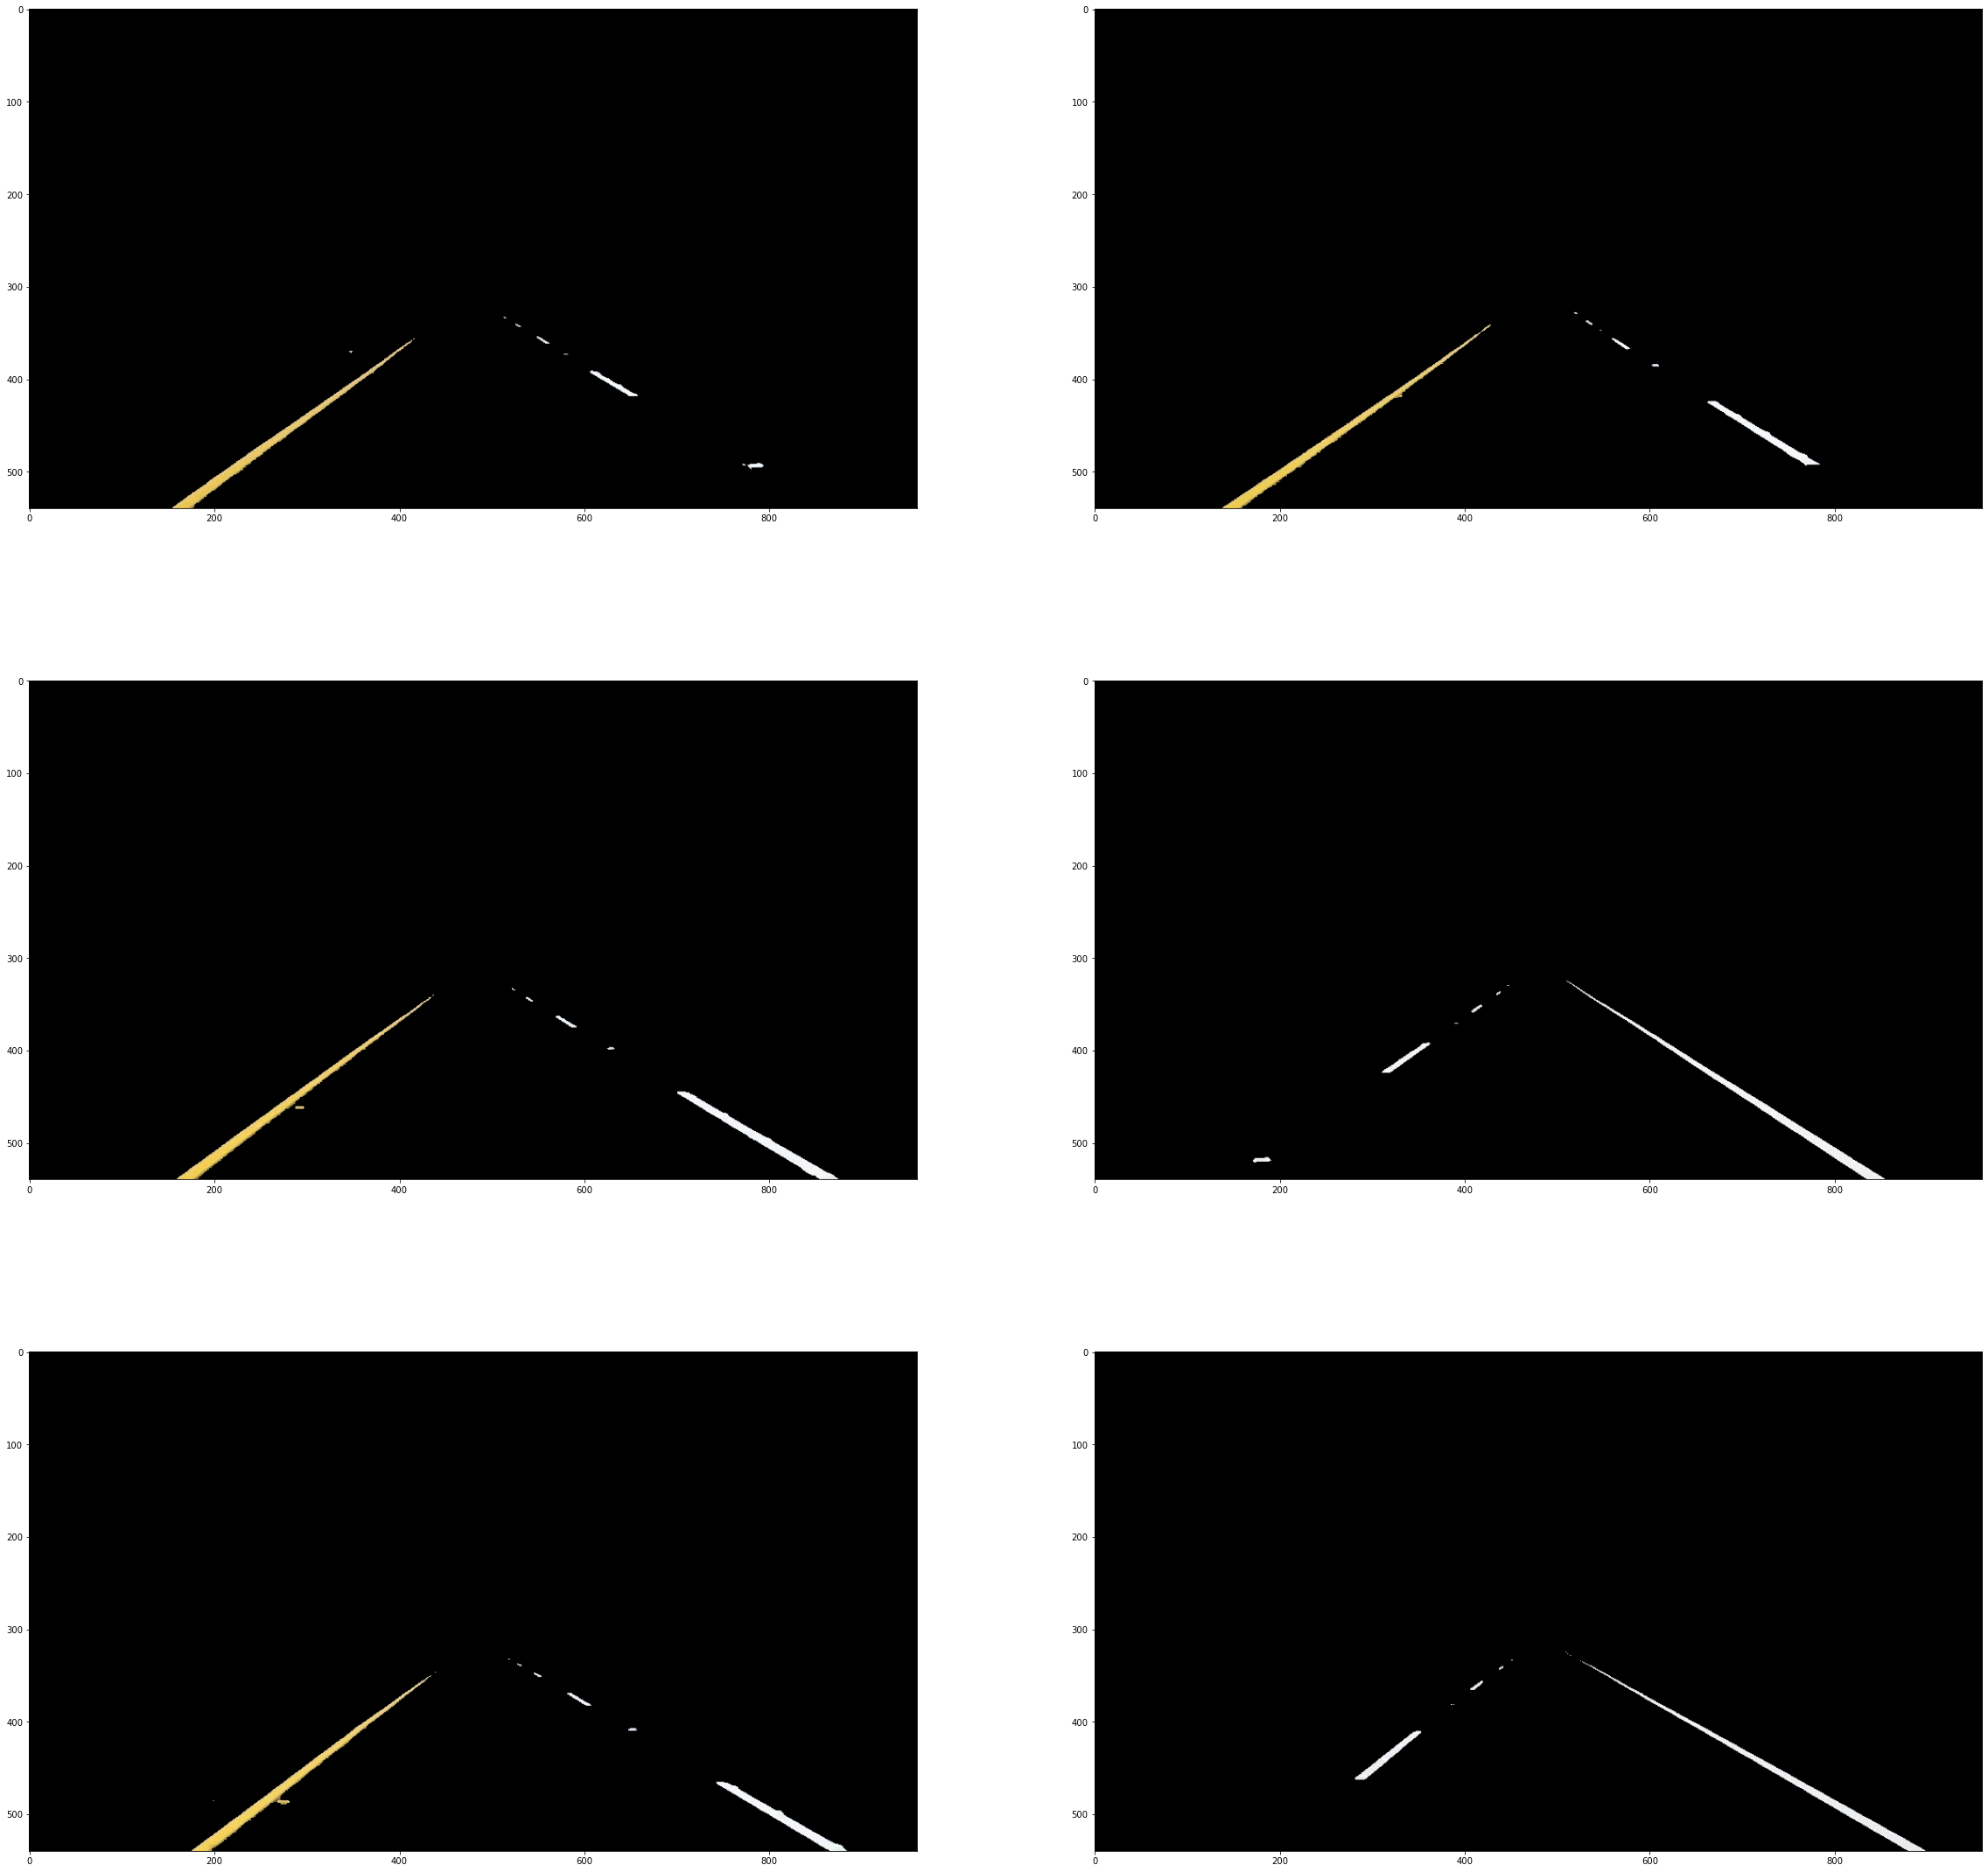

In [5]:
def roi(img):
    x = int(img.shape[1])
    y = int(img.shape[0])
    shape = np.array([[int(0), int(y)], [int(x), int(y)], [int(0.55*x), int(0.6*y)], [int(0.45*x), int(0.6*y)]])

    #define a numpy array with the dimensions of img, but comprised of zeros
    mask = np.zeros_like(img)

    #Uses 3 channels or 1 channel for color depending on input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255

    #creates a polygon with the mask color
    cv2.fillPoly(mask, np.int32([shape]), ignore_mask_color)

    #returns the image only where the mask pixels are not zero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

roi_img = list(map(roi, filtered_img))

display_images(roi_img)

### Edge Detection

我们现在有一张被隔离车道线的图像。现在我们需要计算图像的边缘。我们将通过将输入图像转换为“灰色”色彩空间来做到这一点，然后计算相邻像素的梯度（变化率）。这种使用梯度计算边缘的方法被称为精瘦边缘检测。

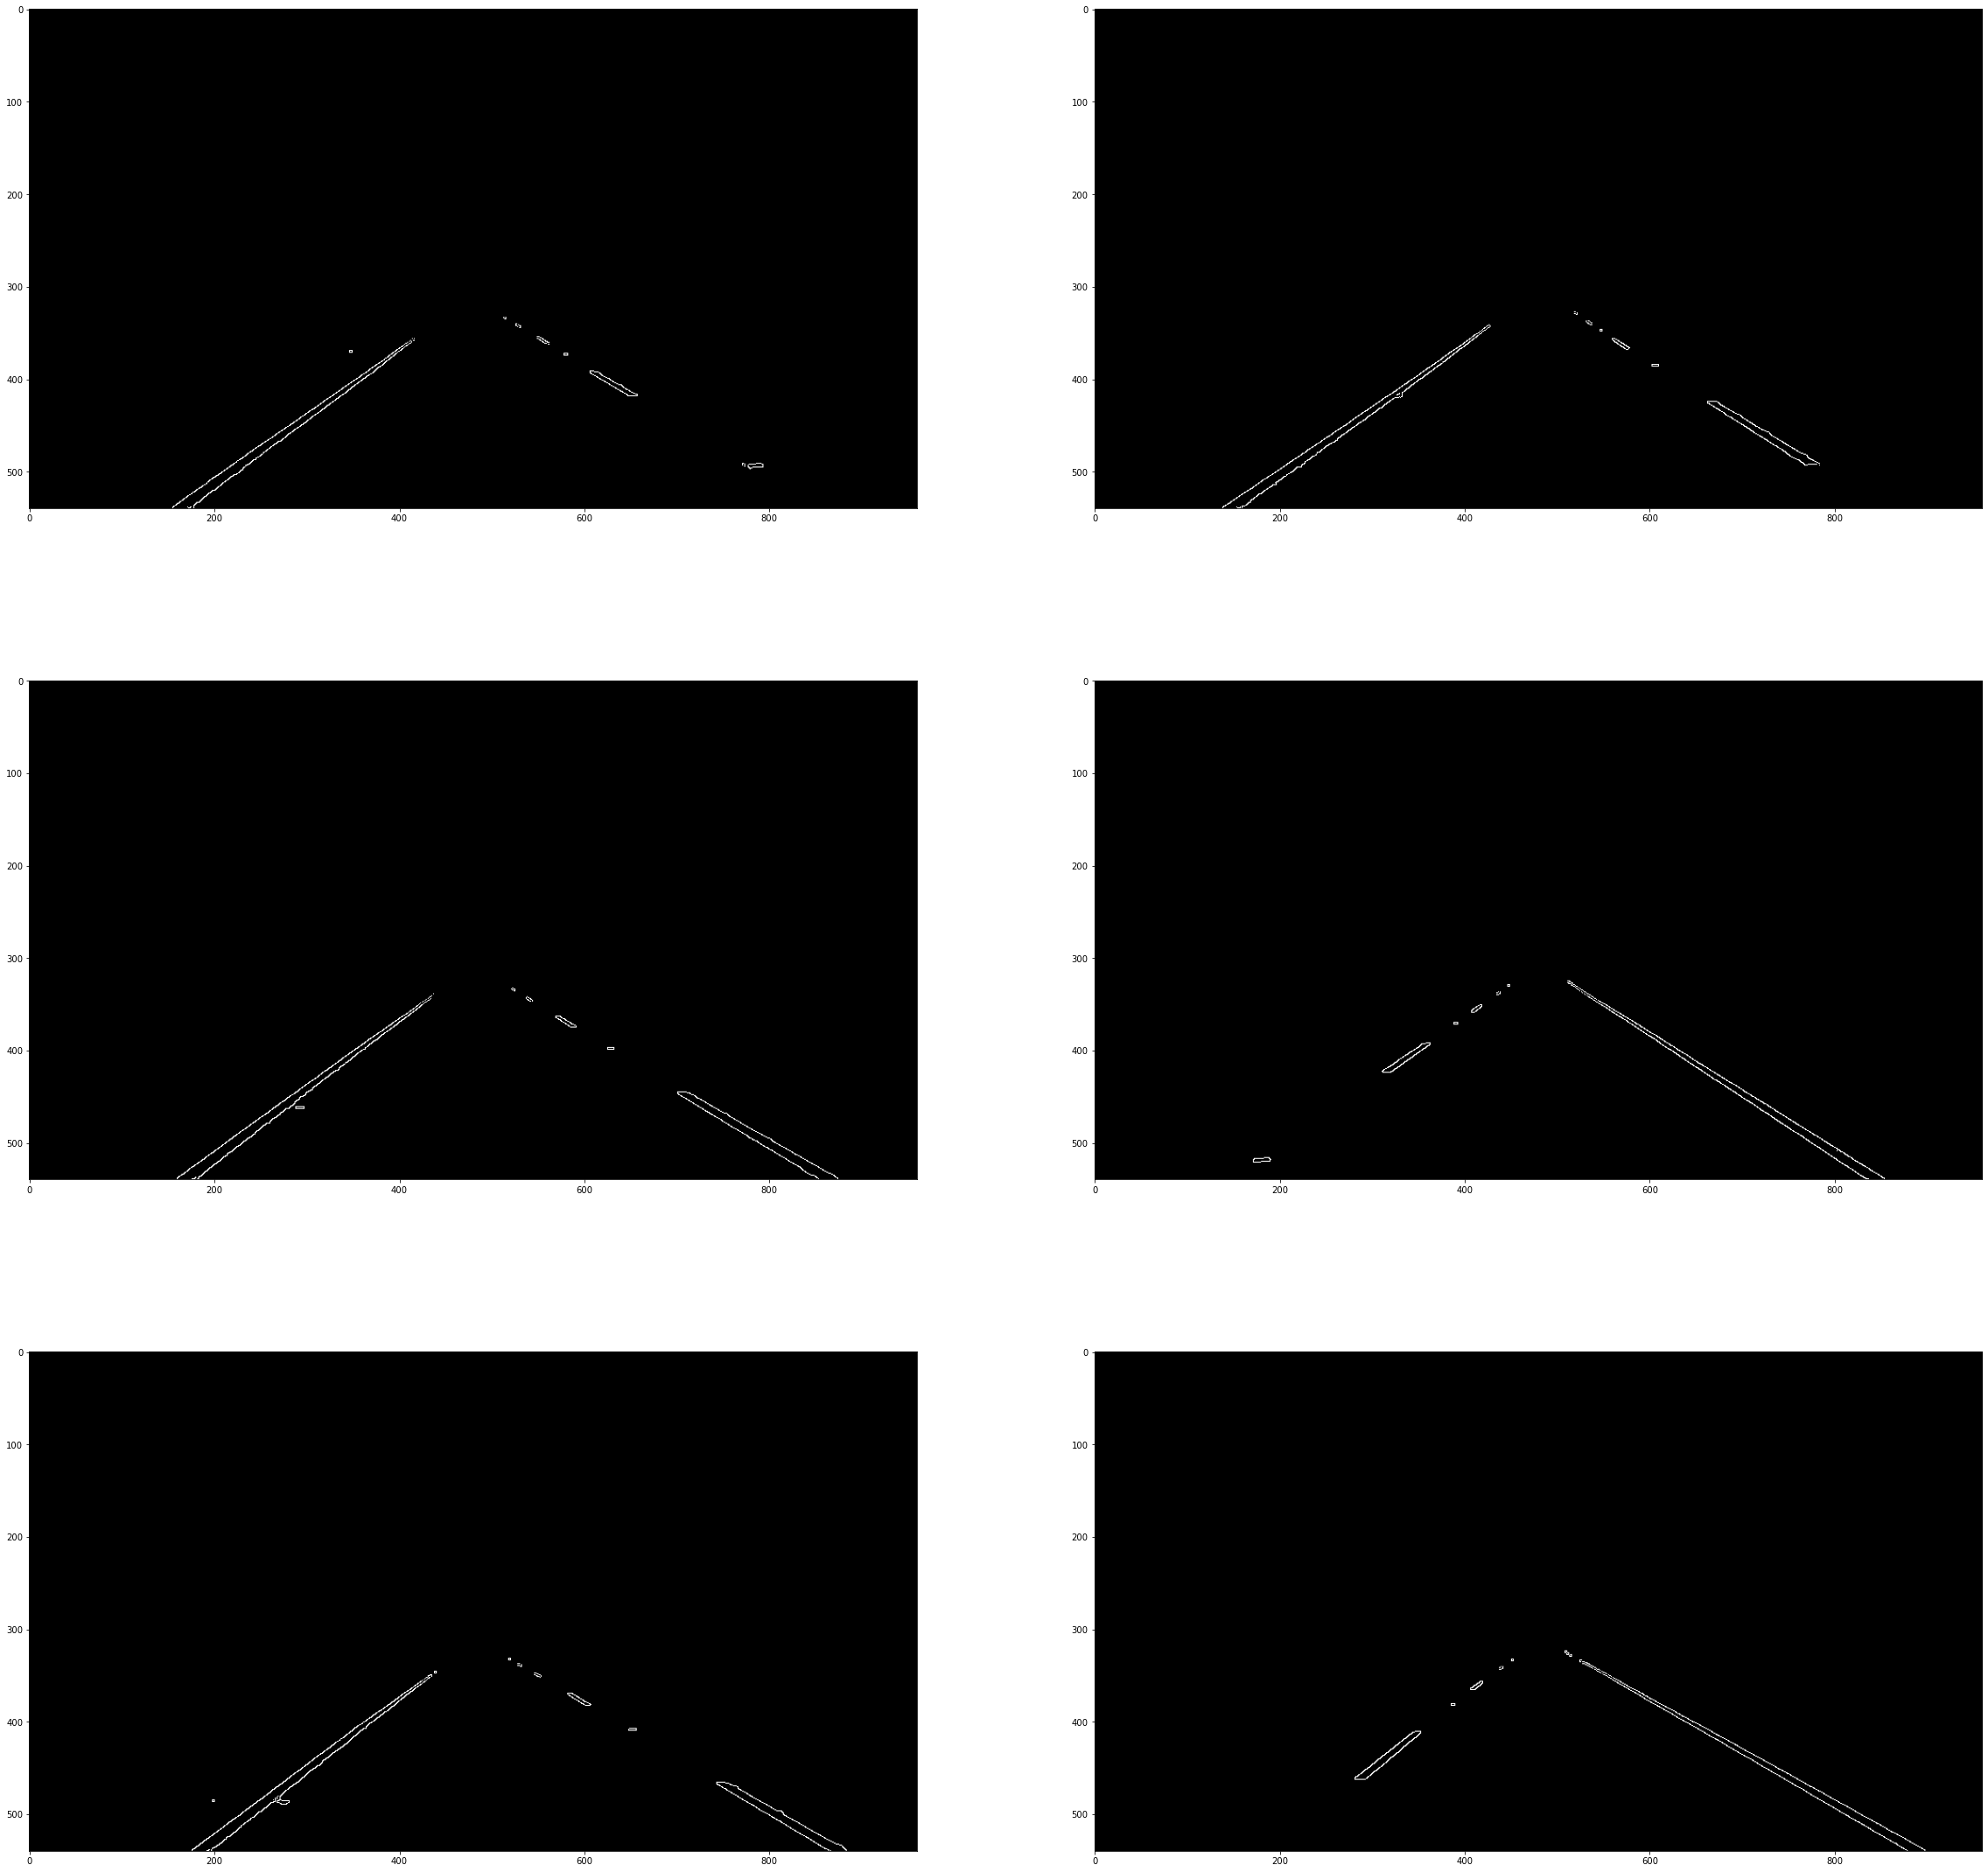

In [8]:
def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

def canny(img):
    return cv2.Canny(grayscale(img), 50, 120)

canny_img = list(map(canny, roi_img))
display_images(canny_img,cmap='gray')

### Finding Lines

这是项目中最困难的部分。我们需要从我们之前检测到的精明边缘确定车道线。

你如何检测线路？我们将使用cv2计算线路。HoughLinesP()，然后过滤掉线条。我们将首先移除在确定的斜坡范围和区域之外的线路。此外，我们将通过查看过滤线是否有正斜率或负斜率来将线路过滤到自己的相应车道上。

现在我们有了与他们的车道相对应的线路；我们如何将它们组合成一条线？接近它的一种方法是使用斜率和断线。我们将计算特定车道上每条线路的斜率和拦截，然后平均斜率和拦截以产生一条线路。我们会对两条车道都这样做。

我们现在在一定程度上准确地检测到了车道，但如果将其应用于视频流，线路会振荡得太多，并且可能会保持不稳定。我们可以通过使用帧间平均值使线路更稳定。基本上，我们将平均之前框架中车道线的斜率和截距。这样，这条线移动得更慢、更准确。

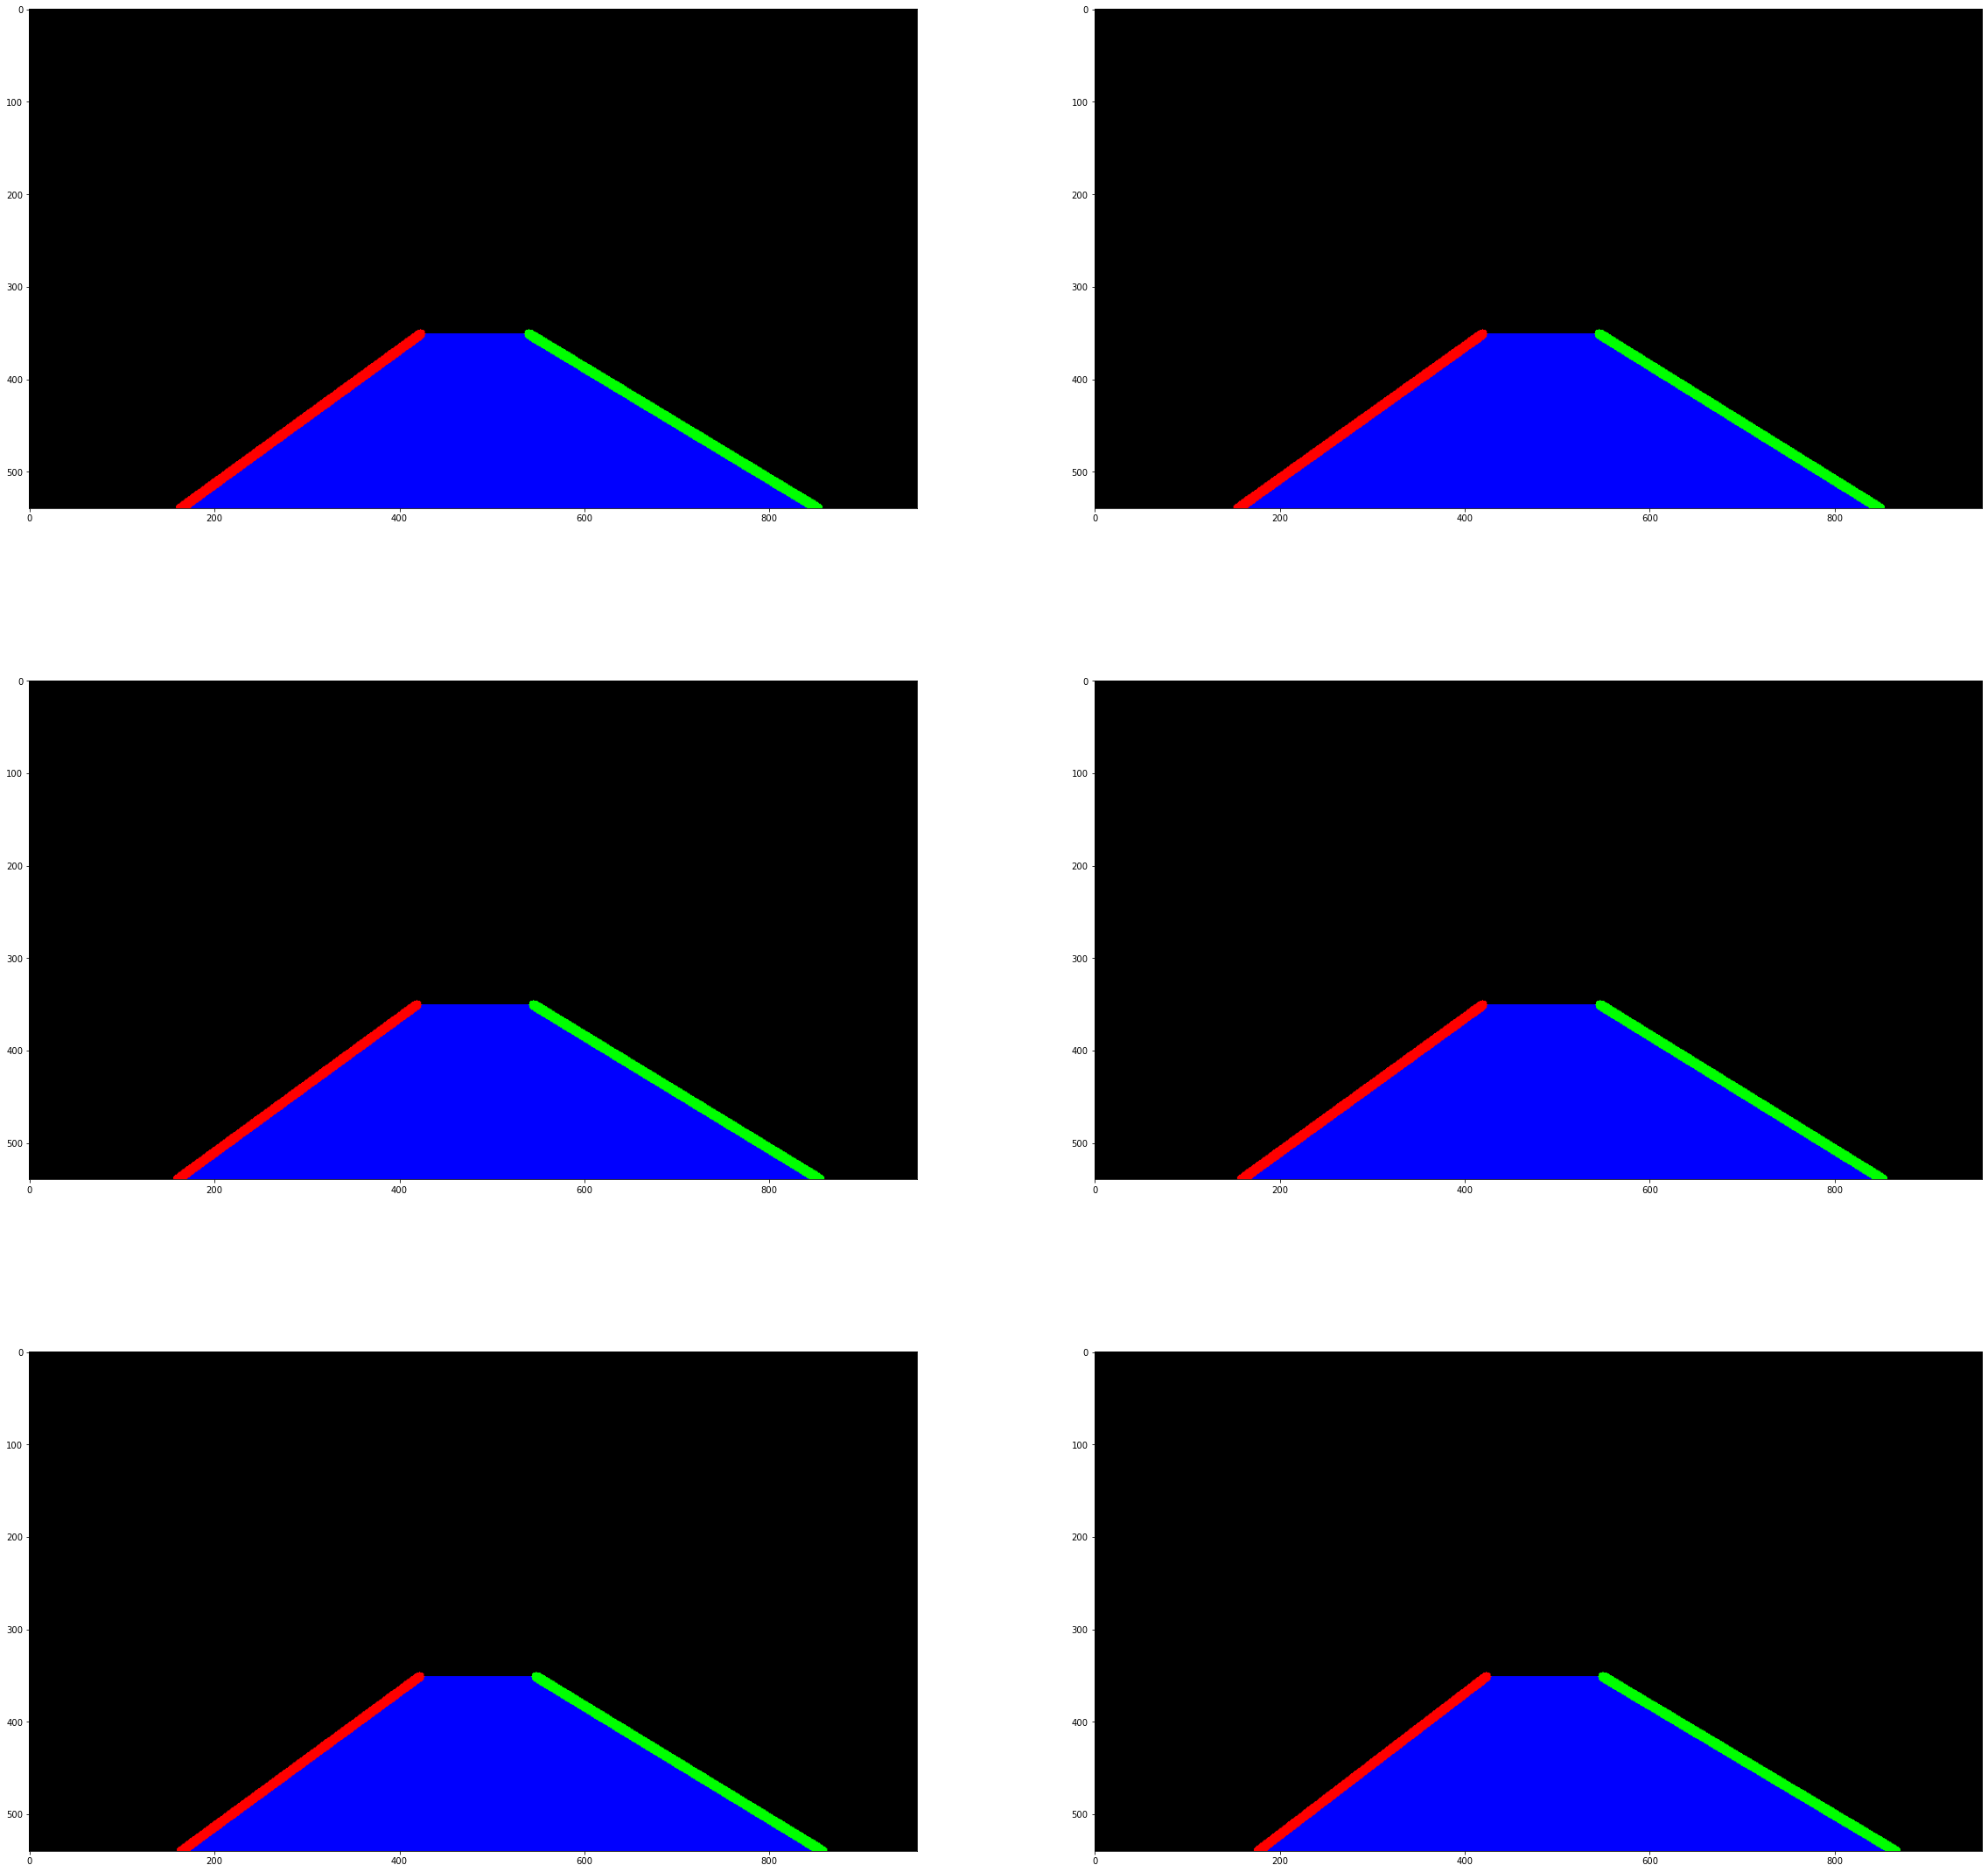

In [9]:
rightSlope, leftSlope, rightIntercept, leftIntercept = [],[],[],[]
def draw_lines(img, lines, thickness=5):
    global rightSlope, leftSlope, rightIntercept, leftIntercept
    rightColor=[0,255,0]
    leftColor=[255,0,0]
    
    #这用于过滤掉可能影响平均值的外线
    #然后，我们使用我们确定的斜率，通过求解y=mx+b中的b来找到滤波线的y截距
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = (y1-y2)/(x1-x2)
            if slope > 0.3:
                if x1 > 500 :
                    yintercept = y2 - (slope*x2)                    
                    rightSlope.append(slope)
                    rightIntercept.append(yintercept)
                else: None                
            elif slope < -0.3:
                if x1 < 600:
                    yintercept = y2 - (slope*x2)                    
                    leftSlope.append(slope)
                    leftIntercept.append(yintercept)    
                    
                    
    #我们使用切片运算符和np.mean()来查找之前30帧的平均值
    #这使得线路更稳定，不太可能快速移动
    leftavgSlope = np.mean(leftSlope[-30:])
    leftavgIntercept = np.mean(leftIntercept[-30:])
    
    rightavgSlope = np.mean(rightSlope[-30:])
    rightavgIntercept = np.mean(rightIntercept[-30:])
    
    
    #在这里，我们使用平均斜率和拦截来绘制车道的线条和形状
    try:
        left_line_x1 = int((0.65*img.shape[0] - leftavgIntercept)/leftavgSlope)
        left_line_x2 = int((img.shape[0] - leftavgIntercept)/leftavgSlope)
    
        right_line_x1 = int((0.65*img.shape[0] - rightavgIntercept)/rightavgSlope)
        right_line_x2 = int((img.shape[0] - rightavgIntercept)/rightavgSlope)

        pts = np.array([[left_line_x1, int(0.65*img.shape[0])],[left_line_x2, int(img.shape[0])],[right_line_x2, int(img.shape[0])],[right_line_x1, int(0.65*img.shape[0])]], np.int32)
        pts = pts.reshape((-1,1,2))
        cv2.fillPoly(img,[pts],(0,0,255))      
        
        
        cv2.line(img, (left_line_x1, int(0.65*img.shape[0])), (left_line_x2, int(img.shape[0])), leftColor, 10)
        cv2.line(img, (right_line_x1, int(0.65*img.shape[0])), (right_line_x2, int(img.shape[0])), rightColor, 10)
    except ValueError:
            #I keep getting errors for some reason, so I put this here. Idk if the error still persists.
        pass
    
    
    
                
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

def linedetect(img):
    return hough_lines(img, 1, np.pi/180, 10, 20, 100)

hough_img = list(map(linedetect, canny_img))
display_images(hough_img)

叠加图像和线条

我们即将结束这个项目，我们现在只需要将检测到的线路和车道覆盖到输入图像上。我们将通过两张图像的加权和来做到这一点。

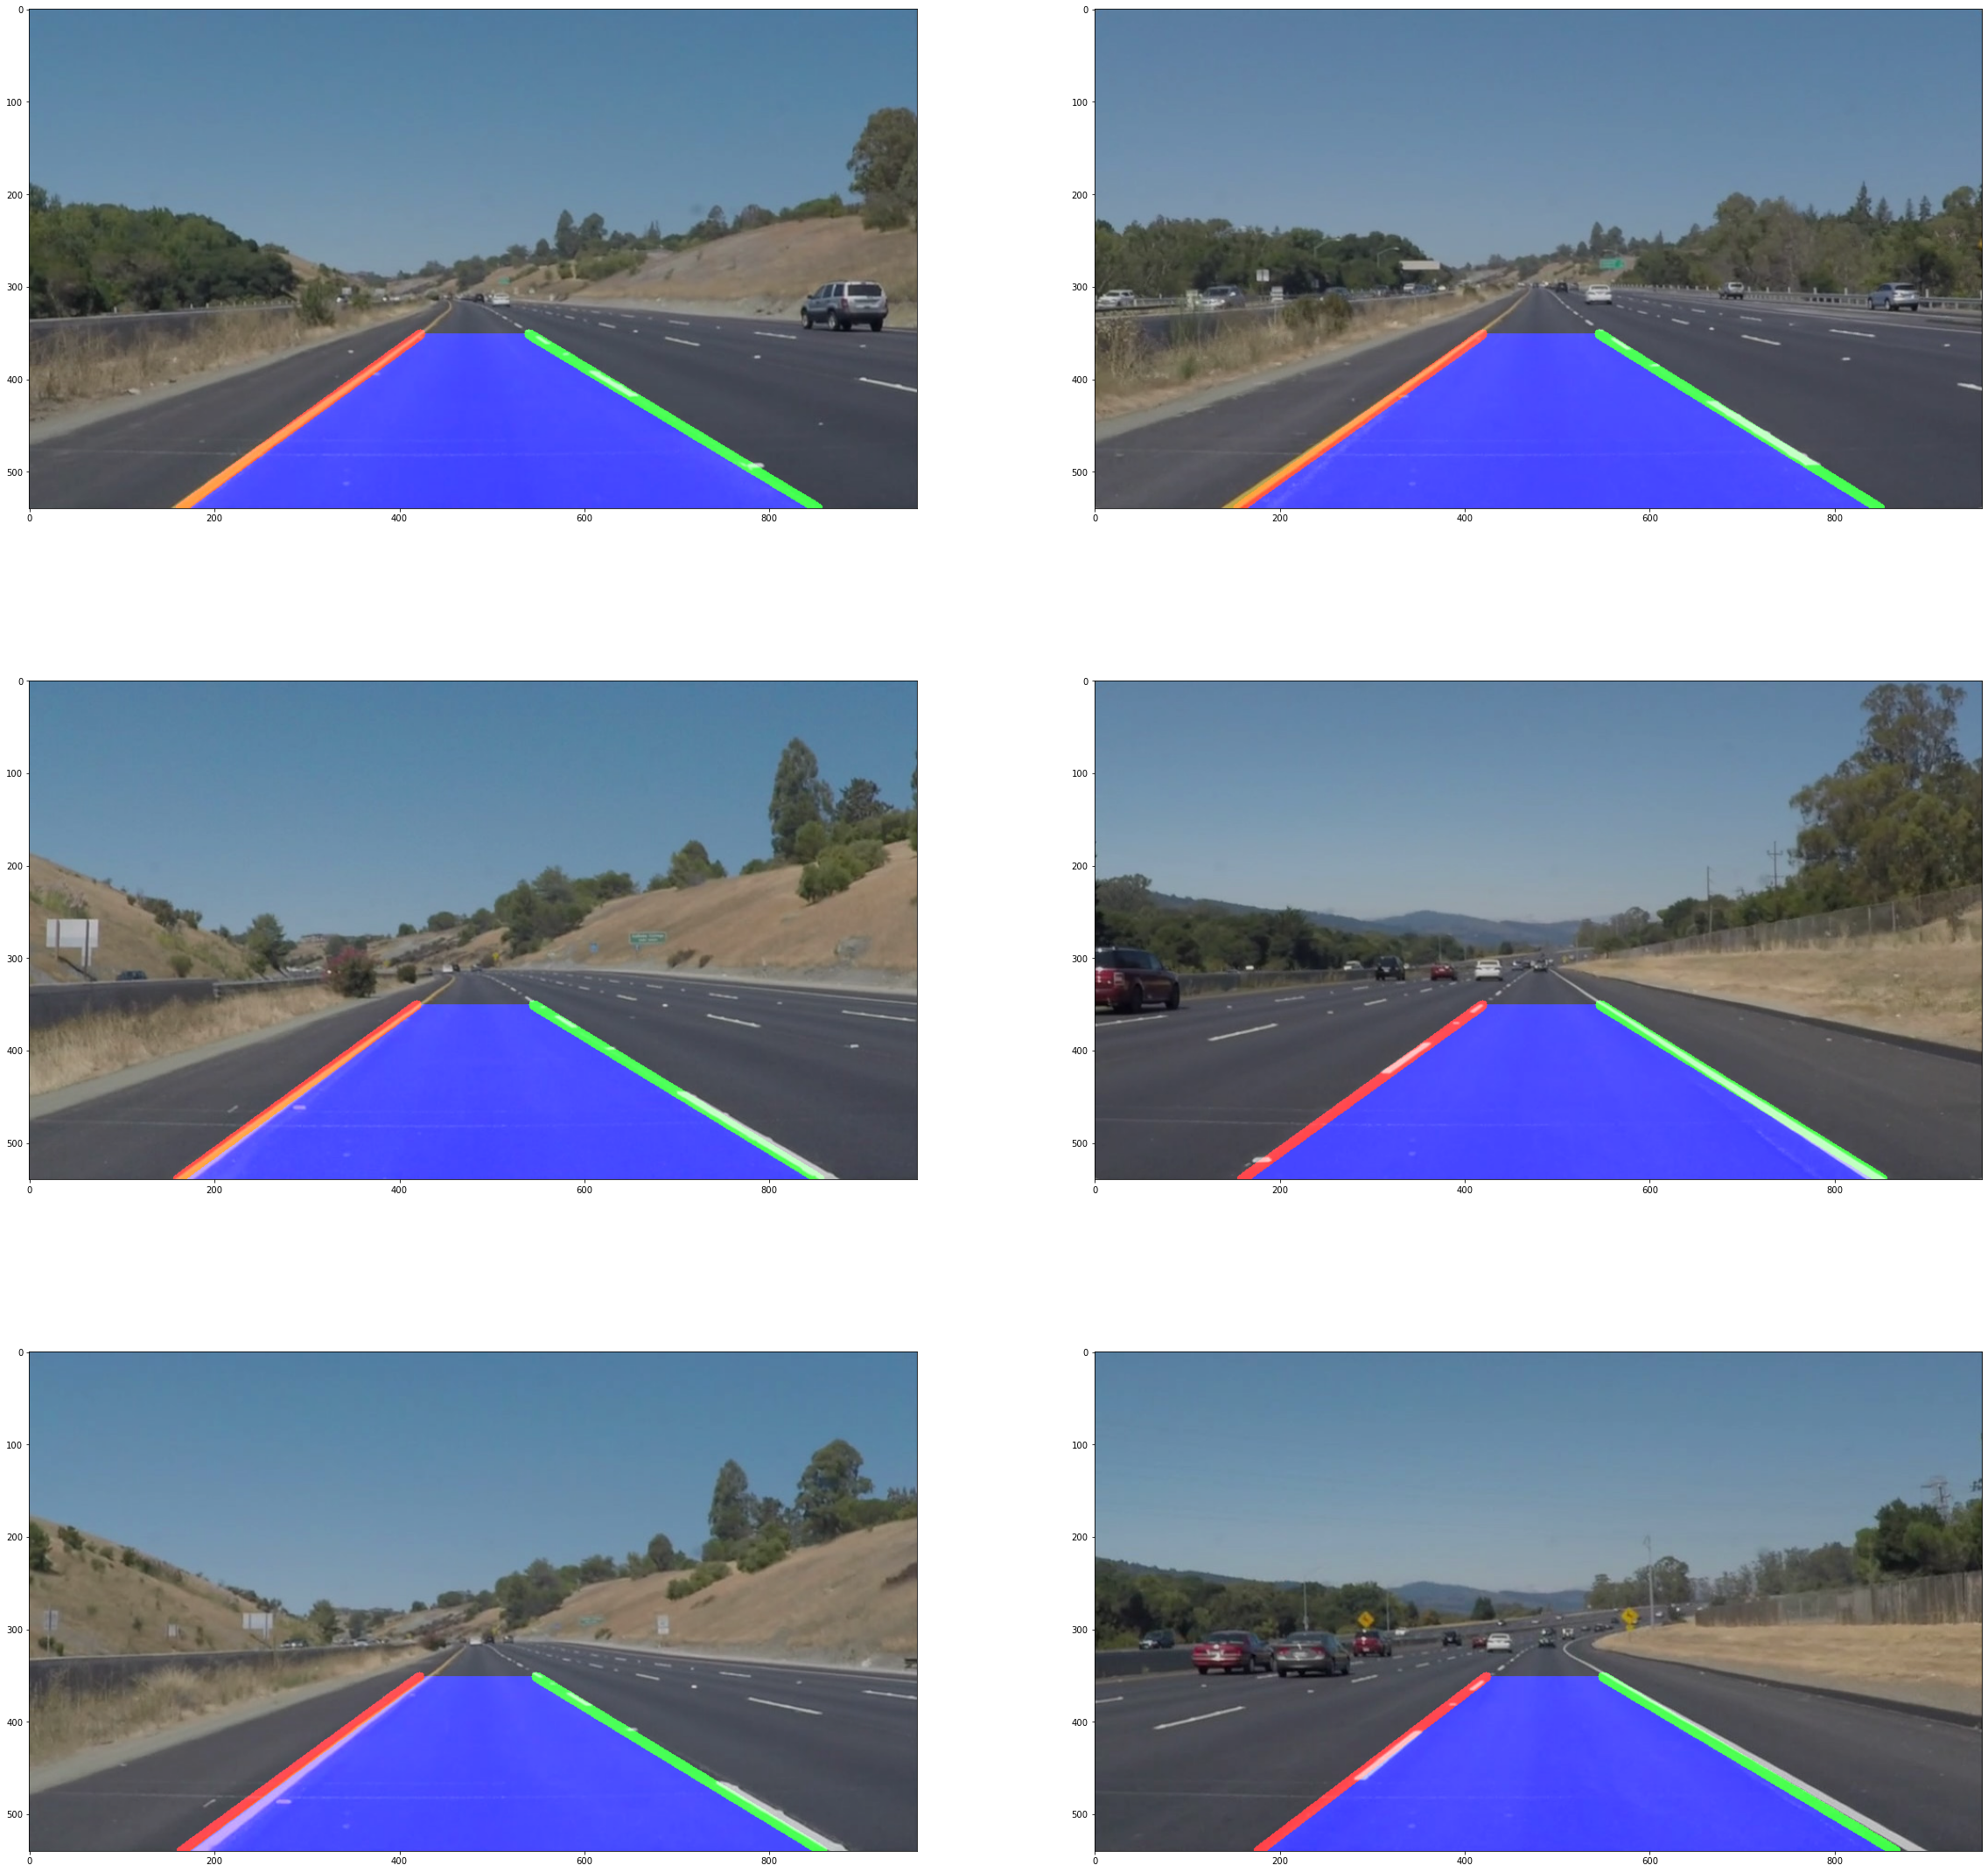

In [10]:
def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

def weightSum(input_set):
    img = list(input_set)
    return cv2.addWeighted(img[0], 1, img[1], 0.8, 0)

result_img = list(map(weightSum, zip(hough_img, imageList)))
display_images(result_img)

Applying it to Video

This project is cool and all, but what good is lane detection without video? We'll be applying the exact same pipeline to our video, then output it.

In [11]:
def processImage(image):
    interest = roi(image)
    filterimg = color_filter(interest)
    canny = cv2.Canny(grayscale(filterimg), 50, 120)
    myline = hough_lines(canny, 1, np.pi/180, 10, 20, 5)
    weighted_img = cv2.addWeighted(myline, 1, image, 0.8, 0)
    
    return weighted_img